In [2]:
# Only these three packages are allowed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class FLD:
    def __init__(self):
        """
            You can add/change any variables/methods to meet your need.
        """
        self.mean_vectors = None
        self.sw = None
        self.sb = None
        self.w = None
        self.slope = None
    def fit(self, X, y):
        #compute each class mean
        self.mean_vectors=np.zeros((3,X.shape[1]))
        C1 = X[np.where(y_train == 0)[0]]
        C2 = X[np.where(y_train == 1)[0]]
        C3 = X[np.where(y_train == 2)[0]]
        self.mean_vectors[0]=np.mean(C1, axis=0)
        self.mean_vectors[1]=np.mean(C2, axis=0)
        self.mean_vectors[2]=np.mean(C3, axis=0)
        #compute sw
        self.sw = np.zeros((X.shape[1], X.shape[1]))
        for i in range(X.shape[0]):
            if y[i]==0:
                self.sw+=np.outer(X[i]- self.mean_vectors[0],X[i]- self.mean_vectors[0])
            elif y[i]==1:
                self.sw+=np.outer(X[i]- self.mean_vectors[1],X[i]- self.mean_vectors[1])
            else:
                self.sw+=np.outer(X[i]- self.mean_vectors[2],X[i]- self.mean_vectors[2])
        #compute sb
        self.sb=np.zeros((X.shape[1],X.shape[1]))    
        N_1=C1.shape[0]
        N_2=C2.shape[0]
        N_3=C3.shape[0]
        m=np.mean(X,axis=0)
        self.sb+=N_1*np.outer(self.mean_vectors[0]-m,self.mean_vectors[0]-m)
        self.sb+=N_2*np.outer(self.mean_vectors[1]-m, self.mean_vectors[1]-m)
        self.sb+=N_3*np.outer(self.mean_vectors[2]-m,self.mean_vectors[2]-m)
        #compute W
        eigvals, eigvecs=np.linalg.eig(np.linalg.inv(self.sw).dot(self.sb))
        sorted_indices = np.argsort(eigvals)[::-1]
        eigvals = eigvals[sorted_indices]
        eigvecs = eigvecs[:, sorted_indices]
        self.w=eigvecs[:, :2]
    def predict_using_class_mean(self, X, y, X_test):
        y_pred=np.zeros(X_test.shape[0])
        for i in range(X_test.shape[0]):
            dist_to_m1 = np.linalg.norm(self.w.dot(self.mean_vectors[0]) - self.w.dot(X_test[i]))
            dist_to_m2 = np.linalg.norm(self.w.dot(self.mean_vectors[1]) - self.w.dot(X_test[i]))
            dist_to_m3 = np.linalg.norm(self.w.dot(self.mean_vectors[2]) - self.w.dot(X_test[i]))
            distances = [dist_to_m1, dist_to_m2, dist_to_m3]
            y_pred[i]=np.argmin(distances) 
        return y_pred
        
    def predict_using_knn(self, X, y, X_test, k=1):
        # return y_pred
        y_pred=np.zeros(X_test.shape[0])
        X_train_proj = X_train.dot(self.w)
        X_test_proj = X_test.dot(self.w)
        for i in range(X_test.shape[0]):
            distances=np.sqrt(np.sum((X_train_proj - X_test_proj[i]) ** 2, axis=1))
            indices = np.argsort(distances)[:k]
            knn_labels = y_train[indices]
            counts = np.bincount(knn_labels.reshape(k))
            y_pred[i] = np.argmax(counts)
        return y_pred
        
    def show_confusion_matrix(self, y, y_pred):
        matrix=np.zeros((3,3))
        for i in range(y_pred.shape[0]):
            if y_pred[i]==y[i][0] and y_pred[i]==0:
                matrix[0][0]+=1
            elif y_pred[i]==y[i][0] and y_pred[i]==1:
                matrix[1][1]+=1
            elif y_pred[i]==y[i][0] and y_pred[i]==2:
                matrix[2][2]+=1
            elif y[i][0]==1 and y_pred[i]==0:
                matrix[1][0]+=1
            elif y[i][0]==2 and y_pred[i]==0:
                matrix[2][0]+=1
            elif y[i][0]==0 and y_pred[i]==1:
                matrix[0][1]+=1
            elif y[i][0]==2 and y_pred[i]==1:
                matrix[2][1]+=1
            elif y[i][0]==0 and y_pred[i]==2:
                matrix[0][2]+=1
            elif y[i][0]==1 and y_pred[i]==2:
                matrix[1][2]+=1
        fig, ax = plt.subplots(figsize=(7.5, 7.5))
        ax.matshow(matrix, cmap=plt.cm.Blues, alpha=0.3)
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                ax.text(x=j, y=i,s=matrix[i, j], va='center', ha='center', size='xx-large')
        plt.xlabel('Predicted label', fontsize=18)
        plt.ylabel('True label', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt.show()

    def plot_projection(self, X, y):
        w=self.w[:,:1]
        X_train_proj = X.dot(w)
        self.slope = float(w[1]/w[0])
        b = -5
        plt.title('Projection Line w = %f, b = %f' % (self.slope, b))
        plt.axis('equal')
        min_X = np.min(X_train_proj)
        max_X = np.max(X_train_proj)

        x_p = np.array([max_X, min_X])
        y_p = self.slope * x_p + b
        plt.plot(x_p, y_p)
        C1 = X[np.where(y_train == 0)[0]]
        C2 = X[np.where(y_train == 1)[0]]
        C3 = X[np.where(y_train == 2)[0]]
        proj_c1 = np.zeros((C1.shape))
        proj_c2 = np.zeros((C2.shape))
        proj_c3 = np.zeros((C3.shape))
        for i, pt in enumerate(C1):
            prj = np.zeros((1, 2), dtype=float)
            t = (-b - self.slope * pt[0] + pt[1]) / (self.slope**2 + 1)
            proj_x = pt[0] + self.slope * t
            proj_y = pt[1] - t
            proj_c1[i] = [proj_x, proj_y]
            plt.plot(proj_x, proj_y, 'b.')

        for i, pt in enumerate(C2):
            prj = np.zeros((1, 2), dtype=float)
            t = (-b - self.slope * pt[0] + pt[1]) / (self.slope**2 + 1)
            proj_x = pt[0] + self.slope * t
            proj_y = pt[1] - t
            proj_c2[i] = [proj_x, proj_y]
            plt.plot(proj_x, proj_y, 'r.')
        for i, pt in enumerate(C3):
            prj = np.zeros((1, 2), dtype=float)
            t = (-b - self.slope * pt[0] + pt[1]) / (self.slope**2 + 1)
            proj_x = pt[0] + self.slope * t
            proj_y = pt[1] - t
            proj_c3[i] = [proj_x, proj_y]
            plt.plot(proj_x, proj_y, 'g.')
        for i in range(len(C1)):
            plt.plot([C1[i][0], proj_c1[i][0]], [C1[i][1], proj_c1[i][1]], 'b.:', linewidth=0.3, alpha=0.5)
        for i in range(len(C2)):
            plt.plot([C2[i][0], proj_c2[i][0]], [C2[i][1], proj_c2[i][1]], 'r.:', linewidth=0.3, alpha=0.5)
        for i in range(len(C3)):
            plt.plot([C3[i][0], proj_c3[i][0]], [C3[i][1], proj_c3[i][1]], 'g.:', linewidth=0.3, alpha=0.5)

    def accuracy_score(self, y, y_pred):
        result=0.0
        for i in range(y.shape[0]):
            if y[i][0]==y_pred[i]:
                result+=1
        return result/y.shape[0]*100

In [3]:
class MultiClassLogisticRegression:
    
    def __init__(self):
        """
            You can add/change any variables/methods to meet your need.
        """
        self.epoch = []
        self.train_loss = []
        self.weights = None
        self.bias=None
    def fit(self, X, y, batch_size=10, lr=0.001, epoch=100):
        #feature=2 classes=3
        self.weights=np.zeros((X.shape[1],3))
        self.weights=self.weights.reshape(X.shape[1],3)
        self.bias=np.zeros((1,3))
        for epoch in range(epoch):
            y_pred=self.predict(X)#1000*3
            y_onehot=np.eye(3)[y].reshape(y.shape[0],3)#1000*3
            d_weight=np.matmul(X.T,(self.predict(X)-y_onehot))/y.shape[0]#2*1000 * 1000*3 = 2*3
            d_bias=np.mean(y_pred-y_onehot,axis=0)
            self.weights-=lr*d_weight  
            self.bias-=lr*d_bias
            self.epoch.append(epoch)
            y_pred=self.predict(X)
            self.train_loss.append(self.cross_entropy(y,y_pred))     
                
    def predict(self, X):
        return self.softmax(X.dot(self.weights)+self.bias)#ok
        
    def evaluate(self, X, y):
        y_pred=self.predict(X)
        return self.accuracy_score(y, y_pred)
        
    def softmax(self, z):#ok
        return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)
        
    def cross_entropy(self, y, probs):#ok 
        loss=np.zeros((y.shape[0]))
        for i in range(y.shape[0]):
            loss[i]=-np.log(probs[i,y[i][0]]) 
        return np.mean(loss) 
    
    def accuracy_score(self, y, y_pred):
        result=0.0
        for i in range(y.shape[0]):
            if y[i][0]==np.argmax(y_pred[i]):
                result+=1
        return result/y.shape[0]*100
    
    def show_confusion_matrix(self, X, y):
        y_pred=self.predict(X)
        final_y=np.zeros((y.shape[0],1))
        for i in range(y.shape[0]):
            final_y[i][0]=np.argmax(y_pred[i])
        matrix=np.zeros((3,3))
        for i in range(final_y.shape[0]):
            if final_y[i][0]==y[i][0] and final_y[i][0]==0:
                matrix[0][0]+=1
            elif final_y[i][0]==y[i][0] and final_y[i][0]==1:
                matrix[1][1]+=1
            elif final_y[i][0]==y[i][0] and final_y[i][0]==2:
                matrix[2][2]+=1
            elif y[i][0]==1 and final_y[i][0]==0:
                matrix[1][0]+=1
            elif y[i][0]==2 and final_y[i][0]==0:
                matrix[2][0]+=1
            elif y[i][0]==0 and final_y[i][0]==1:
                matrix[0][1]+=1
            elif y[i][0]==2 and final_y[i][0]==1:
                matrix[2][1]+=1
            elif y[i][0]==0 and final_y[i][0]==2:
                matrix[0][2]+=1
            elif y[i][0]==1 and final_y[i][0]==2:
                matrix[1][2]+=1
        fig, ax = plt.subplots(figsize=(7.5, 7.5))
        ax.matshow(matrix, cmap=plt.cm.Blues, alpha=0.3)
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                ax.text(x=j, y=i,s=matrix[i, j], va='center', ha='center', size='xx-large')
        plt.xlabel('Predicted label', fontsize=18)
        plt.ylabel('True label', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt.show()
        
    def plot_curve(self):
        plt.title('Training loss')
        plt.xlabel('Epochs')
        plt.ylabel('CE Loss')
        plt.plot(range(len(self.epoch)), self.train_loss, 'b-')
        plt.legend(['Train CE loss'],loc='upper right')
        plt.show()

Prepare data for Q1 ~ Q12

In [3]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW2_blob_train.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW2_blob_test.csv"))

In [4]:
X_train = df_train[['Feature1', 'Feature2']].to_numpy()
y_train = df_train[['Target']].to_numpy().ravel()
X_test = df_test[['Feature1', 'Feature2']].to_numpy()
y_test = df_test[['Target']].to_numpy().ravel()
y_train=y_train.reshape(y_train.shape[0],1)
y_test=y_test.reshape(y_test.shape[0],1)

In [14]:
mean_vectors=np.zeros((3,X_train.shape[1]))
C1 = X_train[np.where(y_train == 0)[0]]
C2 = X_train[np.where(y_train == 1)[0]]
C3 = X_train[np.where(y_train == 2)[0]]
mean_vectors[0]=np.mean(C1, axis=0)
mean_vectors[1]=np.mean(C2, axis=0)
mean_vectors[2]=np.mean(C3, axis=0)
#compute sw
sw = np.zeros((X_train.shape[1], X_train.shape[1]))
for i in range(X_train.shape[0]):
    if y_train[i]==0:
        sw+=np.outer(X_train[i]- mean_vectors[0],X_train[i]- mean_vectors[0])
    elif y_train[i]==1:
        sw+=np.outer(X_train[i]- mean_vectors[1],X_train[i]- mean_vectors[1])
    else:
        sw+=np.outer(X_train[i]- mean_vectors[2],X_train[i]- mean_vectors[2])
#compute sb
sb=np.zeros((X_train.shape[1],X_train.shape[1]))    
N_1=C1.shape[0]
N_2=C2.shape[0]
N_3=C3.shape[0]
m=np.mean(X_train,axis=0)
sb+=N_1*np.outer(mean_vectors[0]-m,mean_vectors[0]-m)
sb+=N_2*np.outer(mean_vectors[1]-m, mean_vectors[1]-m)
sb+=N_3*np.outer(mean_vectors[2]-m,mean_vectors[2]-m)
#compute W
eigvals, eigvecs=np.linalg.eig(np.linalg.inv(sw).dot(sb))
sorted_indices = np.argsort(eigvals)[::-1]
eigvals = eigvals[sorted_indices]
eigvecs = eigvecs[:, sorted_indices]
w=eigvecs[:, :1]
w

(array([40.83222427,  0.13053055]),
 array([[-0.44115384, -0.88607066],
        [-0.8974315 ,  0.46355019]]))

MultiClass Logistic Regression

In [6]:
# For Q1
lr = 0.0005
batch_size = 1000
epoch = 110000
               
logistic_reg = MultiClassLogisticRegression()
logistic_reg.fit(X_train, y_train, lr=lr, batch_size=batch_size, epoch=epoch)

In [7]:
# For Q2
print('Training acc: ', logistic_reg.evaluate(X_train, y_train))

Training acc:  89.60000000000001


In [8]:
# For Q3
print('Testing acc: ', logistic_reg.evaluate(X_test, y_test))

Testing acc:  88.3


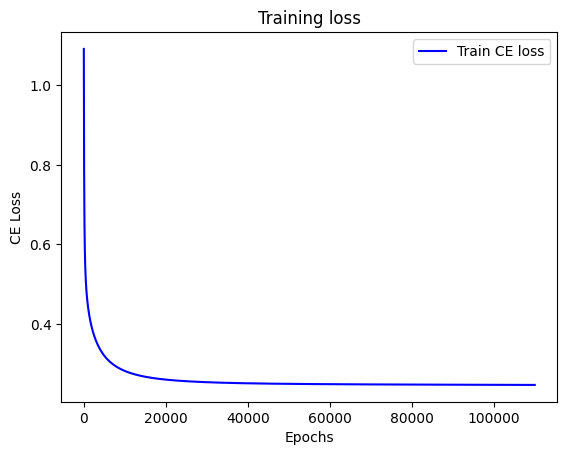

In [9]:
# For Q4
logistic_reg.plot_curve()

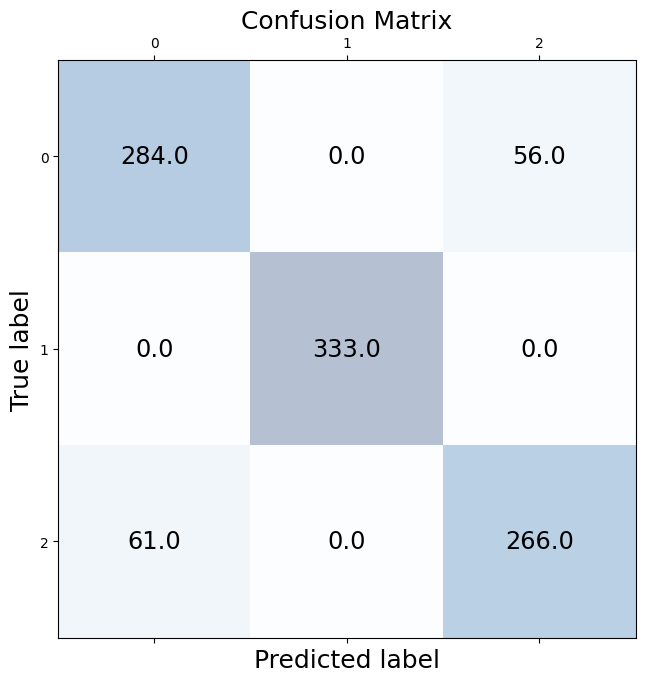

In [10]:
# For Q5
logistic_reg.show_confusion_matrix(X_test, y_test)

Fisher's Linear Discriminant Analysis

In [11]:
fld = FLD()

fld.fit(X_train, y_train)

In [12]:
# For Q6
print("Class 1 mean vector: ", fld.mean_vectors[0])
print("Class 2 mean vector: ", fld.mean_vectors[1])
print("Class 3 mean vector: ", fld.mean_vectors[2])

Class 1 mean vector:  [-4.17505764  6.35526804]
Class 2 mean vector:  [-9.43385176 -4.87830741]
Class 3 mean vector:  [-2.54454008  7.53144179]


In [13]:
# For Q7
print("Within-class scatter matrix SW: ", fld.sw)

Within-class scatter matrix SW:  [[1052.70745046  -12.5828441 ]
 [ -12.5828441   971.29686189]]


In [14]:
# For Q8
print("Between-class scatter matrix SB: ", fld.sb)

Between-class scatter matrix SB:  [[ 8689.12907035 16344.86572983]
 [16344.86572983 31372.93949414]]


In [15]:
# For Q9
print("W: ", fld.w)

W:  [[-0.44115384 -0.88607066]
 [-0.8974315   0.46355019]]


FLD using class mean, accuracy:  88.6


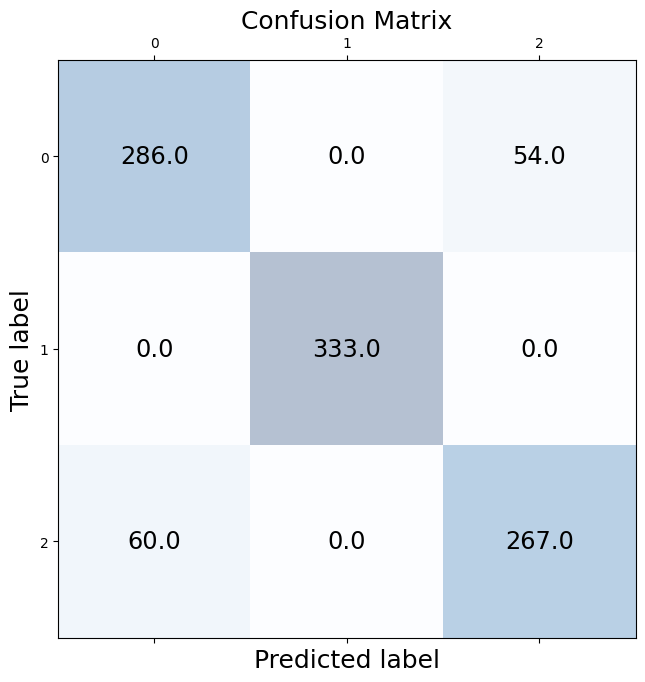

In [16]:
# For Q10
y_pred = fld.predict_using_class_mean(X_train, y_train, X_test)
print("FLD using class mean, accuracy: ", fld.accuracy_score(y_test, y_pred))

fld.show_confusion_matrix(y_test, y_pred)

In [17]:
# For Q11
y_pred_k1 = fld.predict_using_knn(X_train, y_train, X_test, k=1)
print("FLD using knn (k=1), accuracy: ", fld.accuracy_score(y_test, y_pred_k1))

y_pred_k2 = fld.predict_using_knn(X_train, y_train, X_test, k=2)
print("FLD using knn (k=2), accuracy: ", fld.accuracy_score(y_test, y_pred_k2))

y_pred_k3 = fld.predict_using_knn(X_train, y_train, X_test, k=3)
print("FLD using knn (k=3), accuracy: ", fld.accuracy_score(y_test, y_pred_k3))

y_pred_k4 = fld.predict_using_knn(X_train, y_train, X_test, k=4)
print("FLD using knn (k=4), accuracy: ", fld.accuracy_score(y_test, y_pred_k4))

y_pred_k5 = fld.predict_using_knn(X_train, y_train, X_test, k=5)
print("FLD using knn (k=5), accuracy: ", fld.accuracy_score(y_test, y_pred_k5))

FLD using knn (k=1), accuracy:  84.0
FLD using knn (k=2), accuracy:  84.7
FLD using knn (k=3), accuracy:  87.7
FLD using knn (k=4), accuracy:  87.9
FLD using knn (k=5), accuracy:  87.7


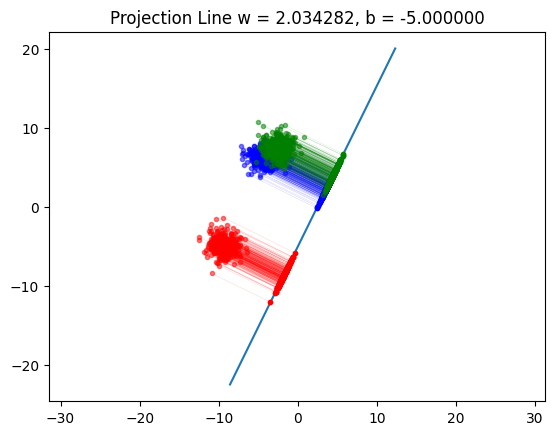

In [18]:
# For Q12, using only training data
fld.plot_projection(X_train, y_train)

Train your own model on provided dataset.
You can only using 1) Fisher's Linear Discriminant or 2) Logistic Regression that you have implemented above.

In [19]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW2_train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW2_val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW2_test.csv"))

In [20]:
df_train.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00668,0.00192,0.682,0.996,2.0
1,0.00680,0.00106,0.503,0.996,1.0
2,0.00742,0.00106,0.482,0.991,1.0
3,0.00685,0.00178,0.650,0.998,2.0
4,0.00680,0.00163,0.623,0.996,2.0


In [21]:
df_test.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00699,0.000877,0.451,0.994,NaN
1,0.00736,0.001370,0.549,0.998,NaN
2,0.00687,0.001420,0.580,0.992,NaN
3,0.00752,0.002520,0.737,0.996,NaN
4,0.00685,0.000910,0.464,0.992,NaN


In [22]:
#training 
train_f1 = df_train[['Feature1']]
train_f1 = train_f1.to_numpy()
train_f3 = df_train[['Feature3']]
train_f3 = train_f3.to_numpy()
X_train = df_train[['Feature2']].copy()
X_train['Fusion']=((train_f1+train_f3))
X_train=X_train.to_numpy()
mu=np.mean(X_train,axis=0)
sigma=np.std(X_train,axis=0)
X_train=(X_train-mu)/sigma
y_train = df_train[['Target']].to_numpy().ravel()
y_train=y_train.astype(int)
#validing
val_f1 = df_val[['Feature1']]
val_f1 = val_f1.to_numpy()
val_f3 = df_val[['Feature3']]
val_f3 = val_f3.to_numpy()
X_val = df_val[['Feature2']].copy()
X_val['Fusion']=((val_f1+val_f3))
X_val=X_val.to_numpy()
mu=np.mean(X_val,axis=0)
sigma=np.std(X_val,axis=0)
X_val=(X_val-mu)/sigma
y_val = df_val[['Target']].to_numpy().ravel()
y_val=y_val.astype(int)
#testing
test_f1 = df_test[['Feature1']]
test_f1 = test_f1.to_numpy()
test_f3 = df_test[['Feature3']]
test_f3 = test_f3.to_numpy()
X_test = df_test[['Feature2']].copy()
X_test['Fusion']=((test_f1+test_f3))
X_test=X_test.to_numpy()
mu=np.mean(X_test,axis=0)
sigma=np.std(X_test,axis=0)
X_test=(X_test-mu)/sigma

y_train=y_train.reshape(y_train.shape[0],1)
y_val=y_val.reshape(y_val.shape[0],1)

In [23]:
fld = FLD()

fld.fit(X_train, y_train)

In [24]:
y_pred_k8 = fld.predict_using_knn(X_train, y_train,X_val, k=8)
print("FLD using knn (k=8), accuracy: ", fld.accuracy_score(y_val, y_pred_k8))

FLD using knn (k=8), accuracy:  91.5068493150685


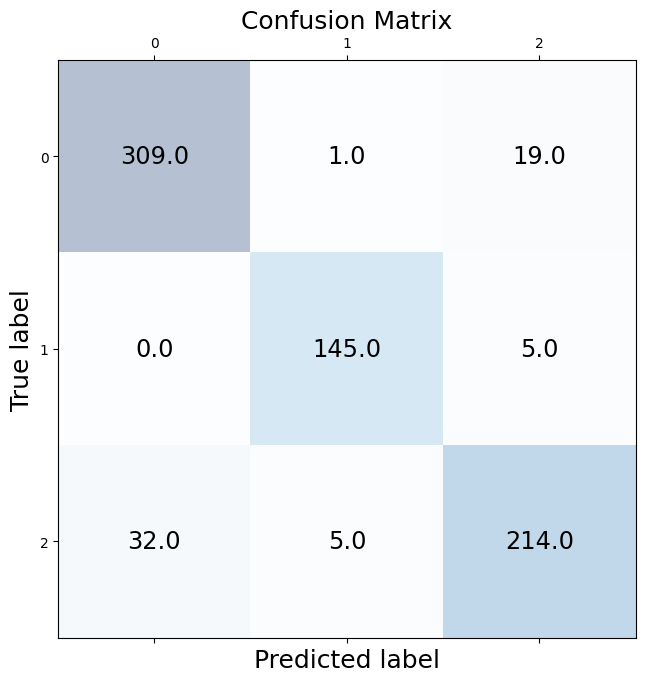

In [25]:
fld.show_confusion_matrix(y_val, y_pred_k8)

In [26]:
test_pred = fld.predict_using_knn(X_train, y_train,X_test, k=8)
print("test_pred shape: ", test_pred.shape)

test_pred shape:  (5677,)


Output the csv file

In [27]:
# For Q13
df_test = pd.DataFrame(pd.read_csv("./PR_HW2_test.csv"))
df_test["Target"] = test_pred
df_test.to_csv("311553046_prediction.csv")